In [12]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import ticker

import flatspin.model
from flatspin.model import CustomSpinIce, SpinIce, SquareSpinIceClosed, IsingSpinIce, PinwheelSpinIceDiamond
from flatspin.encoder import Triangle, AngleTriangle, Angle, AngleSine, Sine
from flatspin.plotting import plot_vectors, vector_colors

from IPython.display import HTML
import textwrap
import pandas as pd

import os
#os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'


12
[ 9 10 11 12]
[ 4  5  6  7  8 13 14 15 16 17 22 23 24 25 26 31 32 33 34 35]
[0.5 0. ] 0.0
[-1. -0.]
[]


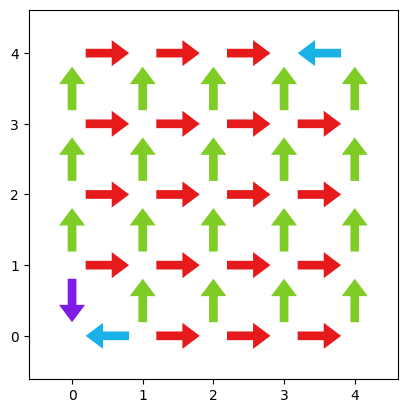

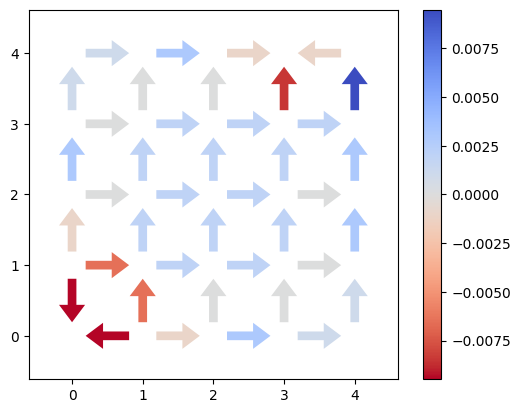

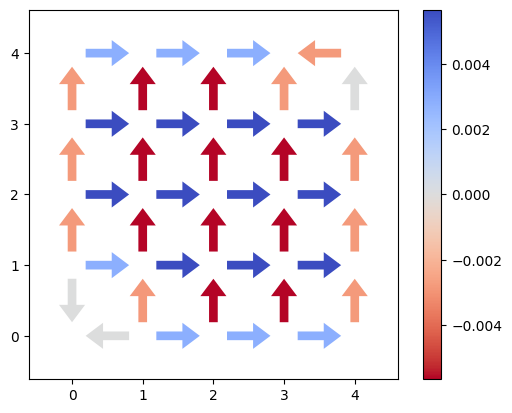

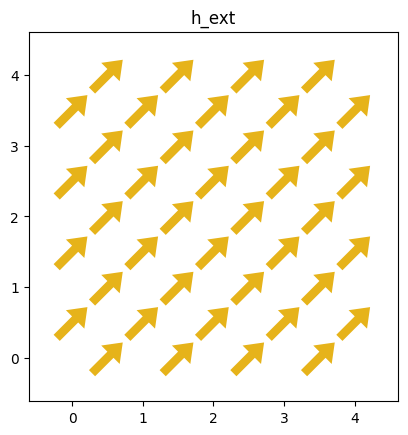

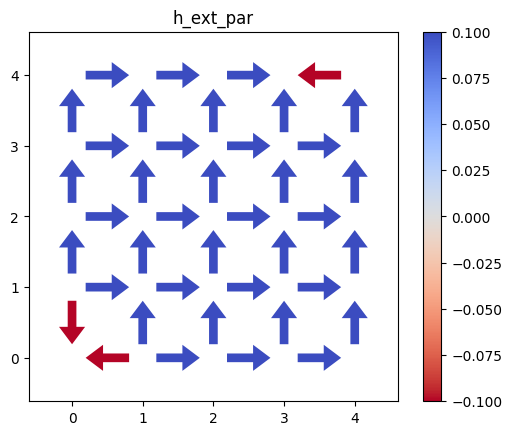

In [10]:
model = SquareSpinIceClosed(use_opencl=True)
model.spin[0] = -1
model.spin[-1] = -1
# model.spin[[0, 4, 39]] = -1
model.flip(4)
plt.figure()
model.plot()

print(model.L[2,3]) #Get index of pos
print(model.L[2])
print(model.L[1::2])
print(model.pos[0], model.angle[0]) #Pos and angle in rad
print(model.vectors[0]) #Magnetization
print(model.flippable())

#m = SquareSpinIceClosed(size=(6,6), neighbor_distance=1) #Alpha higher -> more longrange/more neighbours.


#Dipole fields
plt.figure()
h_dip = model.dipolar_fields()
#print(h_dip)
quiv = model.plot(C=h_dip[:,0], cmap='coolwarm_r')
plt.colorbar(quiv)
#print(h_dip[:,0])

plt.figure()
h_dip = model.dipolar_fields()
quiv = model.plot(C=h_dip[:,1], cmap='coolwarm_r')
plt.colorbar(quiv)



# Global external field
model.set_h_ext([0.1, 0.1])

plt.figure()
plt.title("h_ext")
plot_vectors(model.pos, model.h_ext, normalize=True)

plt.figure()
plt.title("h_ext_par")

h_ext = model.external_fields()

# Colorize spins by the parallel component of the external field
quiv = model.plot(C=h_ext[:,0], cmap='coolwarm_r')
plt.colorbar(quiv)


Text(0.5, 0, 'hc')

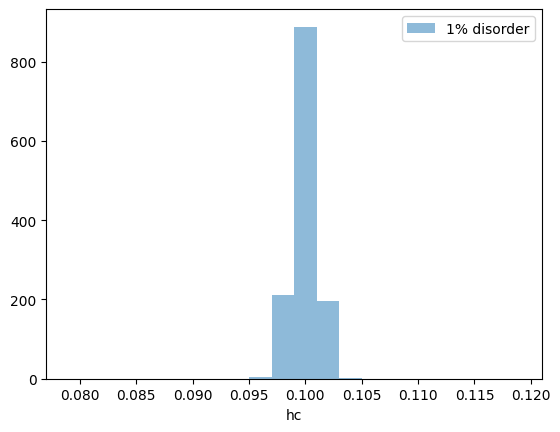

In [22]:
# hc disorder
model1 = SquareSpinIceClosed(size=(25,25), hc=0.1, disorder=0.01)
bins = np.linspace(0.08, 0.12, 21) - 0.001
plt.hist(model1.threshold, bins=bins, label='1% disorder', alpha=0.5)
plt.legend()
plt.xlabel("hc")

In [9]:
#GPU time:
model_cpu = SquareSpinIceClosed(size=(100,100))
%timeit model_cpu.dipolar_fields()
model_gpu = SquareSpinIceClosed(size=(100,100), use_opencl=True)
%timeit model_gpu.dipolar_fields()

881 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.46 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


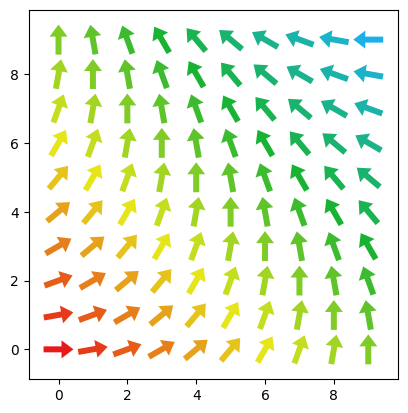

In [12]:
# Custum grid:
size = (10, 10)

# Positions of spins
lattice_spacing = 1
x = lattice_spacing * np.arange(0, size[0])
y = lattice_spacing * np.arange(0, size[1])
xx, yy = np.meshgrid(x, y)
xx = xx.ravel()
yy = yy.ravel()
pos = np.column_stack([xx, yy])

# Angles of spins
delta_angle = 10
angle = (xx+yy) * delta_angle / lattice_spacing

# Give the angles and positions to CustomSpinIce
model = CustomSpinIce(magnet_coords=pos, magnet_angles=angle, radians=False)
model.plot();

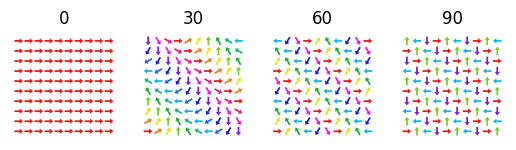

In [14]:
# Custum class:

class MySpinIce(SpinIce):
    def __init__(self, *, delta_angle=10, **kwargs):
        self.delta_angle = delta_angle
        super().__init__(**kwargs)

    def _init_geometry(self):
        # size, lattice_spacing, pos and angle are SpinIce parameters
        size = self.size
        lattice_spacing = self.lattice_spacing

        # positions of spins
        x = lattice_spacing * np.arange(0, size[0])
        y = lattice_spacing * np.arange(0, size[1])
        xx, yy = np.meshgrid(x, y)
        xx = xx.ravel()
        yy = yy.ravel()
        pos = np.column_stack([xx, yy])

        # angles of spins
        delta_angle = np.deg2rad(self.delta_angle)
        angle = (xx+yy) * delta_angle / lattice_spacing

        # Generate labels for our geometry (optional)
        #self.labels = grid

        return pos, angle

    # The size of vertices in our geometry (optional)
    _vertex_size = (2, 2)


for i, delta_angle in enumerate([0, 30, 60, 90]):
    model = MySpinIce(size=(10,10), delta_angle=delta_angle)
    plt.subplot(1, 4, i+1)
    plt.title(f"{delta_angle}")
    plt.axis('off')
    model.plot()

In [32]:
#Switching

def GSW(h_par, h_perp, b=1, c=1, beta=3, gamma=3):
    """ Generalized Stoner-Wohlfarth astroid  """
    sw = b*(1 - ((h_perp/c)**2)**(1/beta))**(gamma/2)
    sw[h_par<0] *= -1
    return sw

def plot_GSW(b=1, c=1, beta=3, gamma=3, ax=None, angle_range=(0, 2*np.pi), **kwargs):
    thetas = np.linspace(angle_range[0], angle_range[1], 3601)

    h_perp = c * np.cos(thetas)
    h_par = b * np.sin(thetas)
    
    kwargs.setdefault("label", rf"$b={b:g}, c={c:g}, \beta={beta:g}, \gamma={gamma:g}$")

    if ax is None:
        ax = plt.gca()
    return ax.plot(h_perp, GSW(h_par, h_perp, b, c, beta, gamma), **kwargs)

def animate_switching(model, H=0.15, phi=-100):
    # Reset system back to the polarized state
    model.polarize()
    hk = model.threshold.reshape((-1,1))

    # Set up figure and axes
    fig = plt.figure(facecolor='white')
    ax_astroid = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
    ax_spin = plt.subplot2grid((2,3), (0,2))
    ax_h_ext = plt.subplot2grid((2,3), (1,2))

    # Set up external field (triangle wave)
    enc = Triangle(timesteps=64, H=H, phi=phi)
    h_ext = enc([1])

    # Plot astroid with field vector
    plt.sca(ax_astroid)
    line, = plot_GSW(*model.sw_params, angle_range=(np.pi, 2*np.pi))
    plot_GSW(*model.sw_params, angle_range=(0, np.pi), ls='dashed', color=line.get_color())
    origin = np.tile([0, 0], (model.spin_count, 1))
    plot_vectors(origin, origin, C=origin[:,0],
                 clim=(-.5,.5), cmap='bwr_r', scale=1, width=.05, pivot='tail', mask_zero=False)
    plt.xlabel('$h_\perp / h_k$')
    plt.ylabel('$h_\parallel / h_k$')

    # spin axis
    plt.sca(ax_spin)
    plt.axis('off')
    plt.title('spin')

    # h_ext axis
    plt.sca(ax_h_ext)
    plt.axis('off')
    plt.title('h_ext')

    def do_cycle():
        for h in h_ext:
            model.set_h_ext(h)
            model.relax()
            h_tot = model.total_fields()
            yield model.total_fields()

    def do_plot(h_tot):
        h_tot /= hk
        h_tot = np.column_stack([h_tot[:,1], h_tot[:,0]])
        plot_vectors(origin, h_tot, C=np.sign(h_tot[:,1]), ax=ax_astroid, replace=True)

        model.plot(ax=ax_spin, replace=True)

        h_ext = model.h_ext / hk
        plot_vectors(model.pos, h_ext, ax=ax_h_ext, replace=True, scale=.5, width=.1)

    anim = FuncAnimation(fig, do_plot, init_func=lambda: None, frames=do_cycle(), interval=200, blit=False)
    plt.close() # Only show the animation
    #anim.save("astroid.gif")
    return HTML(anim.to_jshtml())

model = SquareSpinIceClosed()
model.spin[[0, 4, -1]] = -1

# model = IsingSpinIce(size=(1,1))

# model = IsingSpinIce(size=(1,1), sw_b=1, sw_c=1, sw_beta=3, sw_gamma=3)

animate_switching(model)

In [34]:
#Flip in step

def do_steps():
    yield model
    while model.step():
        yield model

def do_plot(model):
    E = model.switching_energy()
    E_max = np.max(np.abs(E))
    model.plot(C=E, cmap='coolwarm', clim=(-E_max, E_max), ax=ax, replace=True)

model = SquareSpinIceClosed()
model.spin[[0, 4, 39]] = -1
model.set_h_ext([0.2, 0])

fig, ax = plt.subplots()
anim = FuncAnimation(fig, do_plot, frames=do_steps(), interval=500, blit=False)
plt.close() # Only show the animation
HTML(anim.to_jshtml())

In [35]:
#Relaxation

# Strength of external field
H = np.linspace(0, 0.1, 100)
# Direction of the external field
phi = np.deg2rad(180+45)
h_dir = np.array([np.cos(phi), np.sin(phi)])

def do_reversal():
    yield model
    for h in H:
        model.set_h_ext(h * h_dir)
        if model.relax():
            # Only show plot when there were spin flips
            yield model

def do_plot(model):
    model.plot(ax=ax, replace=True)
        
fig, ax = plt.subplots()
anim = FuncAnimation(fig, do_plot, frames=do_reversal(), interval=500, blit=False)
plt.close() # Only show the animation
HTML(anim.to_jshtml())

Text(0, 0.5, 'M_H (a.u.)')

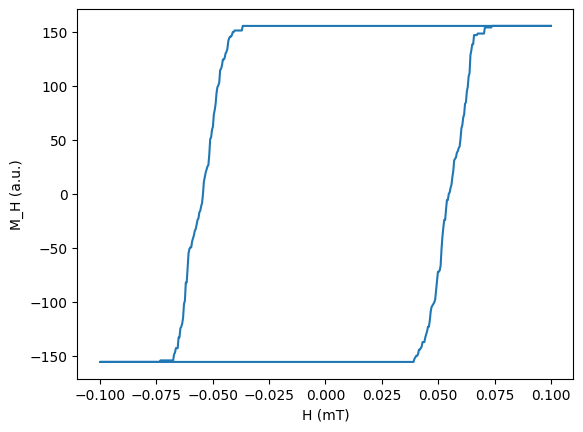

In [47]:
#Hysteresis

model = SquareSpinIceClosed(size=(10,10), disorder=0.1, m_therm=.5e-17) #, use_opencl=True

# H decreases linearly from 0.1 to -0.1, then back to 0.1
H = np.linspace(0.1, -0.1, 500)
H = np.concatenate([H, -H])

# Angle of the external field
phi = np.deg2rad(45)
h_dir = np.array([np.cos(phi), np.sin(phi)])

M_H = []
#model.polarize()
model.set_temperature(400)

for h in H:
    model.set_h_ext(h * h_dir)
    model.relax()
    # Magnetization projected along field direction
    m = model.total_magnetization().dot(h_dir)
    M_H.append(m)

plt.plot(H, M_H)
plt.xlabel("H (mT)")
plt.ylabel(r"M_H (a.u.)")

In [69]:
#Encoder

def animate_h_ext(h_ext, title="", interval=100, cmap='rainbow'):
    fig, ax = plt.subplots()
    
    # Axes setup
    ax.set_title(textwrap.fill(title))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    # Normalize vectors to unit length
    nmax = np.max([norm(h_ext.reshape((-1,2)), axis=-1)])
    if nmax != 0:
        h_ext /= nmax

    # Positions of vectors
    if len(h_ext.shape) == 4:
        # Spatial field
        xx, yy = np.meshgrid(np.arange(h_ext.shape[1]), np.arange(h_ext.shape[2]))
        XY = np.column_stack([xx.ravel(), yy.ravel()])
    else:
        # Global field (single arrow)
        XY = [[0,0]]

    # Colors
    C = np.linspace(0, 1, len(XY), endpoint=False)
    
    def do_animate(i):
        plot_vectors(XY, h_ext[i], C, clim=(0, 1), cmap=cmap, ax=ax, replace=True, mask_zero=False)

    anim = FuncAnimation(fig, do_animate, frames=len(h_ext), interval=interval, blit=False)
    plt.close() # Only show the animation
    return HTML(anim.to_jshtml(fps=1000/interval))

# Encode input as the angle of triangle wave, between 0 and 22 degrees
encoder = AngleSine(H=0.1, phi=22, timesteps=16)
input = [1, -1]
h_ext = encoder(input)
#print(h_ext)

animate_h_ext(h_ext, str(encoder))

In [9]:
# Dataset

# Model parameters
model_params = {
    'size': (4, 4),
    'disorder': 0.05,
    #'use_opencl': True,
}

# Encoder parameters
encoder_params = {
    'H': 0.2,
    'phi': 30,
    'phase': 270,
}

# Create the model object
model = PinwheelSpinIceDiamond(**model_params)

# Create the encoder
encoder = Triangle(**encoder_params)

# Use the encoder to create a global external field
input = [1]
h_ext = encoder(input)

# Save spin state over time
spin = []

# Loop over field values and flip spins accordingly
for h in h_ext:
    model.set_h_ext(h)
    model.relax()
    # Take a snapshot (copy) of the spin state
    spin.append(model.spin.copy())

# Create two tables, one for m_tot and one for h_ext
result = {}
result['spin'] = pd.DataFrame(spin)
result['spin'].index.name = 't'
result['h_ext'] = pd.DataFrame(h_ext, columns=['h_extx', 'h_exty'])
result['h_ext'].index.name = 't'

display(result['spin'])
display(result['h_ext'])


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
t                                                                            
0    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
1    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
2    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
3    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
4    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
95   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
96   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
97   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
98   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
99   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   

    18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
t                                                                            
0    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
1    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
2    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
3    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
4    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
95   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
96   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
97   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
98   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
99   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   

    36  37  38  39  
t                   
0    1   1   1   1  
1    1   1   1   1  
2    1   1   1   1  
3    1   1   1   1  
4    1   1   1   1  
..  ..  ..  ..  ..  
95   1   1   1   1  
96   1   1   1   1  
97   1   1   1   1  
98   1   1   1   1  
99   1   1   1   1  

[100 rows x 40 columns]

h_extx  h_exty
t                   
0   0.000000   0.000
1  -0.006928  -0.004
2  -0.013856  -0.008
3  -0.020785  -0.012
4  -0.027713  -0.016
..       ...     ...
95  0.034641   0.020
96  0.027713   0.016
97  0.020785   0.012
98  0.013856   0.008
99  0.006928   0.004

[100 rows x 2 columns]

In [14]:
#dataset 2
import os
import shutil
import flatspin
from flatspin.data import Dataset

# Where to store the dataset and results
basepath = '/tmp/flatspin/mydataset'
if os.path.exists(basepath):
    shutil.rmtree(basepath)

# Create params dictionary
# We store both the model params and encoder params
# (there is no overlap between model and encoder params)
params = model_params.copy()
params.update(encoder.get_params())

# Create info dictionary (misc info)
info = {
    'model': f'{model.__class__.__module__}.{model.__class__.__name__}',
    'version': flatspin.__version__,
    'comment': 'My simple dataset'
}

# Create the index table, with a single entry for the above run
# The index must contain a column named 'outdir' which points
# to the location of the result directory / archive file
outdir = 'myrun.npz'
index = pd.DataFrame({'outdir': [outdir]})

# Create the dataset directory
os.makedirs(basepath)

# Create the dataset object
dataset = Dataset(index, params, info, basepath)

print("Saving dataset:", repr(dataset))
dataset.save()

Saving dataset: Dataset('/tmp/flatspin/mydataset'): 1 items
